<a href="https://colab.research.google.com/github/tosif91/CNN_MelomaAssignment/blob/main/Tosif_Khan_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [47]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [10]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#unziping the loaded folder
!unzip /content/gdrive/MyDrive/CNN_Images/CNN_assignment.zip

In [14]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [17]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [18]:
## Write your validation dataset here
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

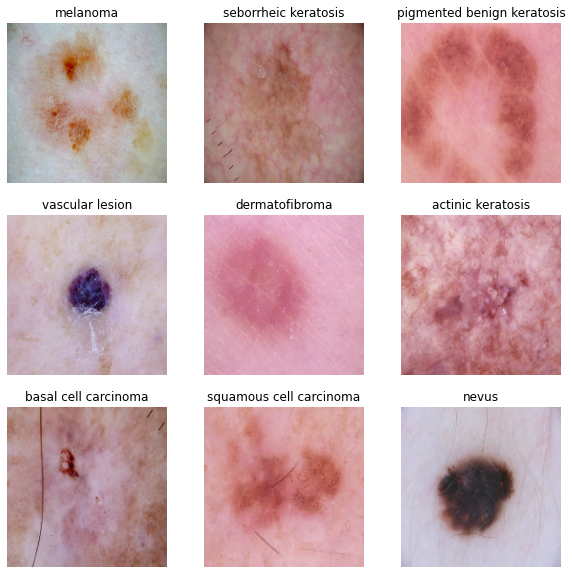

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
seen = []
image_count = 0
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(10):
  for i in range(batch_size):
    if class_names[labels[i]] not in seen:
      seen.append(class_names[labels[i]])
      ax=plt.subplot(3,3,image_count+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      image_count+=1
  if len(seen)>9:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
### Your code goes here
model = keras.Sequential([
                          tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # 3 because it is an RGB layer
                          layers.Conv2D(16 , 3, padding="same", activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Conv2D(32, 3, padding="same", activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Conv2D(64, 3, padding="same", activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Flatten(),
                          layers.Dense(128, activation="relu"),
                          layers.LeakyReLU(256),
                          # layers.Dense(32, activation="relu"),
                          layers.Dense(len(class_names))
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 73ms/step - loss: 2.0586 - accuracy: 0.2494 - val_loss: 1.8745 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7672 - accuracy: 0.3733 - val_loss: 1.7165 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5419 - accuracy: 0.4609 - val_loss: 1.5370 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4031 - accuracy: 0.5078 - val_loss: 1.4547 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3374 - accuracy: 0.5485 - val_loss: 1.4532 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2114 - accuracy: 0.5653 - val_loss: 1.5106 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1322 - accuracy: 0.5882 - val_loss: 1.4042 - val_accuracy: 0.5257
Epoch 8/20
5

### Visualizing training results

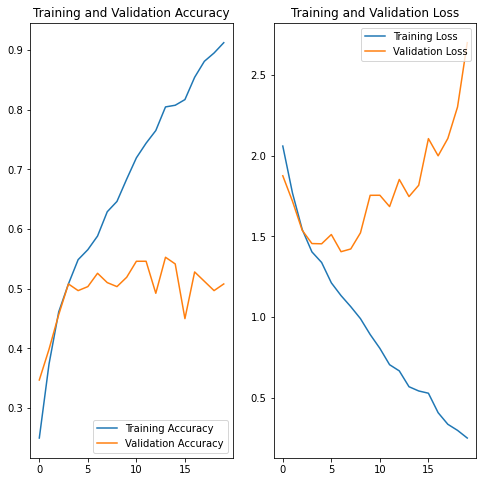

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Here we can clearly see that our model is overfitting,

- Our Training accuracy is 91% 
- Test accuracy as 50.7%

This is clear sign of overfitting

The second figure shown that our loss gone up

In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),
    ]
)

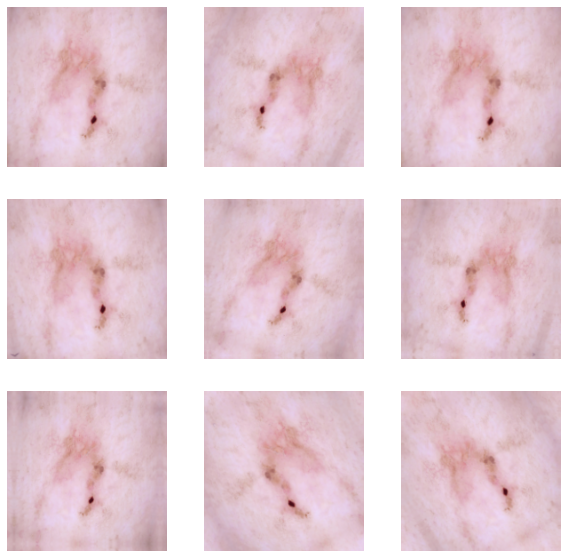

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([                     
                    data_augmentation,
                    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # 3 because it is an RGB layer
                    layers.Conv2D(16 , 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.3),
                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.LeakyReLU(256),
                    # layers.Dense(32, activation="relu"),
                    layers.Dense(len(class_names)),
                    layers.Dropout(0.2)

])


### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.1046 - accuracy: 0.2160 - val_loss: 1.9753 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.9305 - accuracy: 0.2868 - val_loss: 1.7474 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7738 - accuracy: 0.3577 - val_loss: 1.6324 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7133 - accuracy: 0.3817 - val_loss: 1.6001 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6343 - accuracy: 0.4174 - val_loss: 1.7327 - val_accuracy: 0.3490
Epoch 6/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6206 - accuracy: 0.4090 - val_loss: 1.5170 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.5520 - accuracy: 0.4498 - val_loss: 1.5124 - val_accuracy: 0.4564
Epoch 8/20
56

### Visualizing the results

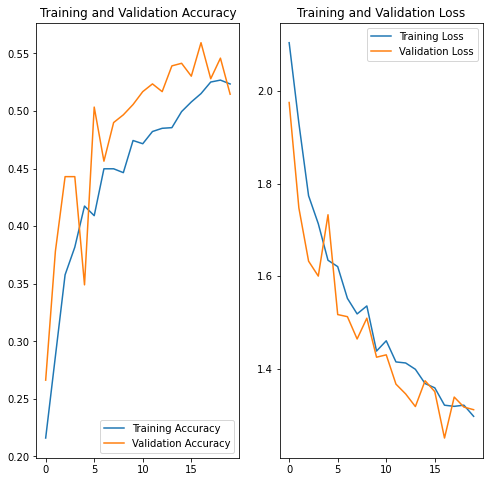

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- After finished the Data augmentation, our Overfitting problem get rectified but the accuracy rate is very low

- We need to improve that

- So i go further and check the class imbalance and handle that as well for improve our accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
## Your code goes here.
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
val_counts=original_df['Label'].value_counts()
val_counts


pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

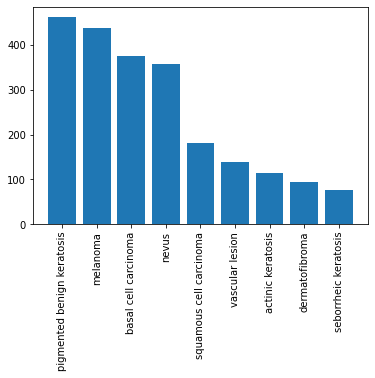

In [41]:
plt.bar(val_counts.keys(), height=val_counts.values)
plt.xticks(rotation=90)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

- While visualize the distribution we can clearly see that The distribution of dermatofibroma,seborrheic keratosis is very low
- At the same time distribution of squamous cell carcinoma,vascular lesion,actinic keratosis are also low but not too low as above category of disease

#### - Which classes dominate the data in terms proportionate number of samples?

While checking the plot of the distribution ,count of pigmented benign keratosis,melanoma,basal cell carcinoma,nevus,these counts are huge and these classes will dominate the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [46]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7B3385BB90>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7B325002D0>: 100%|██████████| 500/500 [00:17<00:00, 28.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7B32500190>: 100%|██████████| 500/500 [00:17<00:00, 28.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7B3399ED90>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F7B32586BD0>: 100%|██████████| 500/500 [01:25<00:00,  5.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7B3259E210>: 100%|██████████| 500/500 [00:17<00:00, 29.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7B33832790>: 100%|██████████| 500/500 [00:45<00:00, 11.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7B338DCC50>: 100%|██████████| 500/500 [00:18<00:00, 27.03 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7B338CE790>: 100%|██████████| 500/500 [00:17<00:00, 28.15 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030191.jpg_ca71fa0b-eeed-45e2-9de9-ea8a164f33ad.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031692.jpg_0242beaf-a33d-40ff-8242-64b0a59d9507.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026152.jpg_a6552ee0-e8e2-4c11-a934-6af227f87ab2.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029462.jpg_83f67d6b-6620-4da1-9886-7db84f7b87f0.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028335.jpg_242f313d-fb82-482e-84eb-3e23

In [51]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [55]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [56]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [57]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [59]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [61]:
## your code goes here
# define the layer of CNN model

model = keras.Sequential()

# bring values between 0 to 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))),

# convolution Layer and Max Layers
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization()),

#Flatten the outputs of hidden layer
model.add(Flatten())

# Dense Layers
model.add(Dense(512, activation='relu'))
# add dropout to reduce overfitting
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# the output layer
model.add(Dense(len(class_names)))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [62]:

#Compile the Network
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#### **Todo:**  Train your model

In [63]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 28s 156ms/step - loss: 1.7202 - accuracy: 0.3761 - val_loss: 2.4260 - val_accuracy: 0.1210
Epoch 2/30
169/169 [==============================] - 24s 136ms/step - loss: 1.1778 - accuracy: 0.5792 - val_loss: 2.3373 - val_accuracy: 0.2064
Epoch 3/30
169/169 [==============================] - 24s 136ms/step - loss: 0.9462 - accuracy: 0.6667 - val_loss: 1.2765 - val_accuracy: 0.5449
Epoch 4/30
169/169 [==============================] - 24s 137ms/step - loss: 0.7834 - accuracy: 0.7329 - val_loss: 0.9002 - val_accuracy: 0.6882
Epoch 5/30
169/169 [==============================] - 24s 137ms/step - loss: 0.6612 - accuracy: 0.7749 - val_loss: 0.7632 - val_accuracy: 0.7365
Epoch 6/30
169/169 [==============================] - 24s 136ms/step - loss: 0.5686 - accuracy: 0.8086 - val_loss: 0.6450 - val_accuracy: 0.7803
Epoch 7/30
169/169 [==============================] - 24s 135ms/step - loss: 0.4896 - accuracy: 0.8333 - val_loss: 0.6484 - val_ac

#### **Todo:**  Visualize the model results

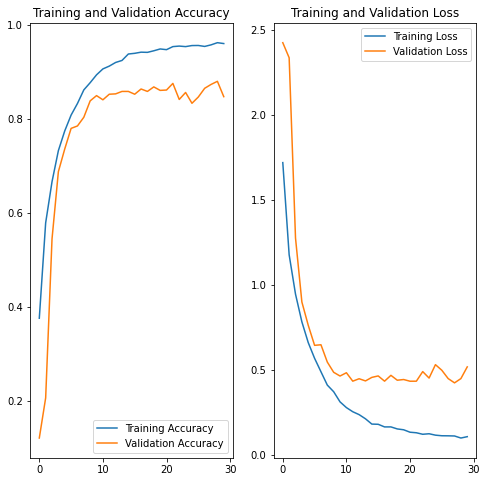

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Final insights**

- After done Class imbalance our model accuracies get increase both validation and train accuracies

- The final accuracy i get for train data is 96 and val accuracy as 85 

- This one is may seen like a overfitting because it has nealy 11% difference, because the epoch which we used is only 30, if we increase that may val accuracy is also will increase, but that need some computational power

- After handled imbalance my accuracies get increased